# TODO
- add more info about candidates (optional/unlikely)

In [29]:
# ledb_candid #Unique identifier for the candidate in the dataset.
# fips #Federal Information Processing Standards code for the geographic area of the election

# district #The district or region within the geographic area (e.g., "Los Angeles").
# votes # The number of votes received by the candidate in the election
# vote_share #  The percentage of the total vote share received by the candidate  - we will have to softmax this
# n_winners # The number of winners for this election - check this
# winner # Indicates whether the candidate won the election 
# incumbent # indicates whether the candidate was an incumbent
# contributor.cfscore # CFscore, a measure of the candidate's ideological position based on campaign finance data (negative values = more liberal, positive values = more conservative)
# prob_democrat # The probability that the candidate is a Democrat
# pid_est # The estimated party ID of the candidate (D for Democrat, R for Republican, etc.).
# prob_male # The probability that the candidate is male
# gender_est # The estimated gender of the candidate (e.g., "M" for male, "F" for female).
# prob_black # Probability that the candidate is Black 
# prob_white # Probability that the candidate is White
# prob_hispanic # Probability that the candidate is Hispanic
# prob_asian # Probability that the candidate is Asian
# prob_other # Probability that the candidate is other
# race_est # The estimated race

# year # The year of the election
# contest # Unique identifier for the specific election contest

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

In [31]:
# Load the data
df = pd.read_csv('data/candidates.csv')
df_mayor = df[df['office_consolidated'] == 'Mayor']

In [32]:
# Drop columns that are not useful
columns_shared_across_candidates = ['state_abb', 'geo_name', 'year', 'contest', 'fips']
columns_individual_candidate = ['full_name', 'vote_share', 'incumbent', 'contributor.cfscore', 'prob_democrat', 'gender_est', 'race_est', 'pid_est']
columns_to_drop = df_mayor.columns.difference(columns_shared_across_candidates + columns_individual_candidate)

df_mayor = df_mayor.drop(columns=columns_to_drop)

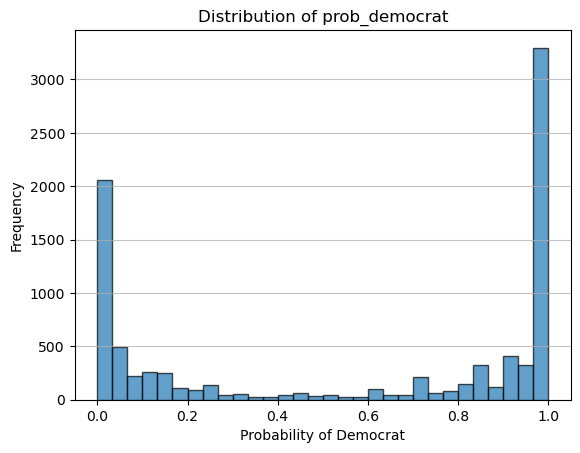

In [33]:
# Display distribution of "prob_democrat"
df_mayor['prob_democrat'].plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

plt.title('Distribution of prob_democrat')
plt.xlabel('Probability of Democrat')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

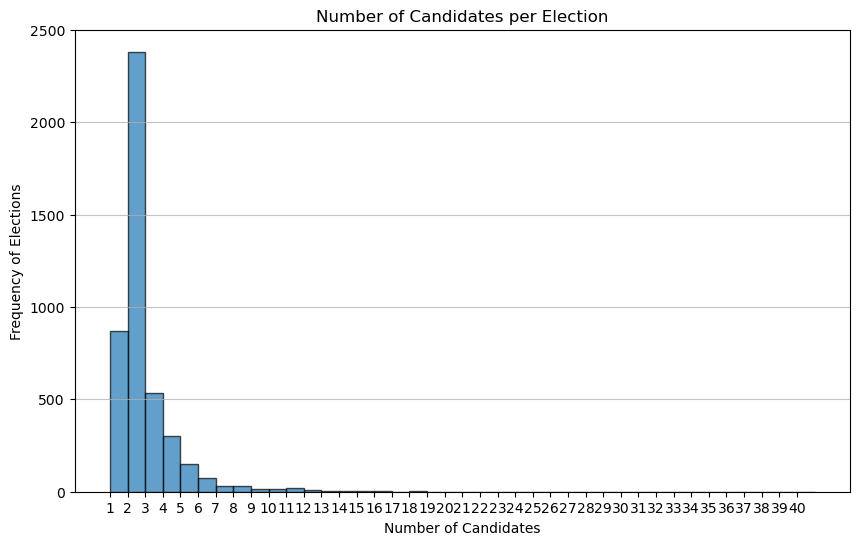

In [34]:
# Display distribution of "contributor.cfscore"
candidates_per_contest = df_mayor.groupby('contest').size()

plt.figure(figsize=(10, 6))
plt.hist(candidates_per_contest, bins=range(1, candidates_per_contest.max() + 2), edgecolor='black', alpha=0.7)
plt.title('Number of Candidates per Election')
plt.xlabel('Number of Candidates')
plt.ylabel('Frequency of Elections')
plt.xticks(range(1, candidates_per_contest.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

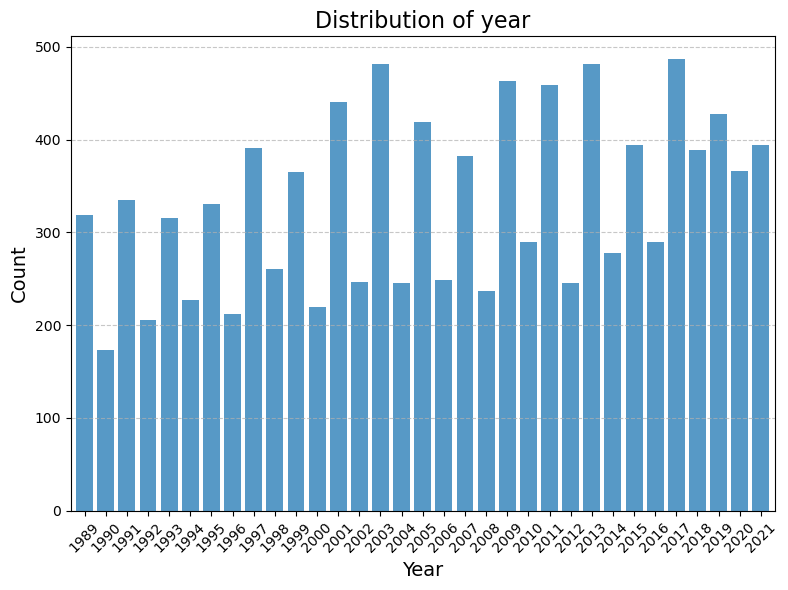

In [35]:
# Display distribution of "year"
year_counts = df_mayor["year"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
year_counts.plot(kind='bar', width=0.8, alpha=0.75)
plt.title("Distribution of year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [36]:
def process_contests(df, columns_shared_across_candidates, columns_individual):
    """
    Processes a DataFrame of election data to combine the top two candidates
    from contests where there are at least two candidates, ensuring the Republican
    candidate comes first and the Democrat second.
    Returns:
        pd.DataFrame: Processed DataFrame with combined candidate data for each contest.
    """
    def reorder_candidates(group):
        """
        Ensures the Republican candidate appears as the first row in the group.
        """
        if group.iloc[0]['pid_est'] != 'R':
            group.iloc[[0, 1]] = group.iloc[[1, 0]].copy()
        return group

    def combine_candidates(group):
        """
        Combines the top two candidates into a single row for a contest.
        """
        combined = {col: group.iloc[0][col] for col in columns_shared_across_candidates}
        for i, suffix in enumerate(['_rep', '_dem']):
            for col in columns_individual:
                combined[f"{col}{suffix}"] = group.iloc[i][col]
        return pd.Series(combined)

    # Filter contests with at least two candidates
    df = df.groupby('contest').filter(lambda x: len(x) >= 2)

    # Sort candidates by vote share within each contest
    df = df.sort_values(by=['contest', 'vote_share'], ascending=[True, False])

    # Select top two candidates per contest
    df = df.groupby('contest').head(2)

    # Keep contests where the top two candidates are from different parties
    df = df.groupby('contest').filter(lambda x: x['pid_est'].nunique() == 2)

    # Ensure Republican candidate is listed first
    df = df.groupby('contest', group_keys=False).apply(reorder_candidates).reset_index(drop=True)

    # Combine candidates into a single row per contest
    df = df.groupby('contest', group_keys=False).apply(combine_candidates).reset_index(drop=True)

    return df


In [37]:
# Process the mayor data
df_mayor = process_contests(df_mayor, columns_shared_across_candidates, columns_individual_candidate)

# Load and preprocess the city constituency data
df_city_consituency = pd.read_csv('data/cities_constituency.csv')
columns_city_consituency_to_drop = [
    'geo_name', 'index', 'state',
    'mass_ideology_2020_se', 'geo_type', 'population_2020',
    'mass_ideology_2020', 'percent_white', 'percent_black',
    'percent_hispanic', 'percent_asian_american'
]

df_city_consituency = df_city_consituency.drop(columns=columns_city_consituency_to_drop)
df_city_consituency['fips'] = df_city_consituency['fips'].astype(int)

# Ensure FIPS codes are integers in both DataFrames
df_mayor['fips'] = df_mayor['fips'].astype(int)

# Merge the DataFrames on FIPS
df_mayor = pd.merge(df_mayor, df_city_consituency, on='fips', how='left')

# Normalize vote_shares
denominator = df_mayor['vote_share_rep'] + df_mayor['vote_share_dem']
df_mayor['vote_share_rep'] = df_mayor['vote_share_rep'] / denominator
df_mayor['vote_share_dem'] = df_mayor['vote_share_dem'] / denominator

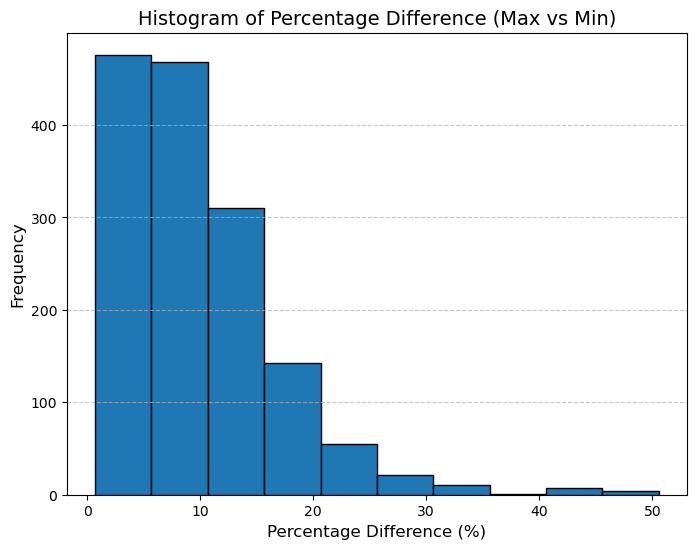

In [38]:
# Calculate max-min difference and percentage difference without modifying the original data
max_min_diff = df_mayor[["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"]].max(axis=1) - df_mayor[["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"]].min(axis=1)
percent_diff = (max_min_diff / df_mayor[["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"]].mean(axis=1)) * 100

# Plot histogram of percentage differences
plt.figure(figsize=(8, 6))
plt.hist(percent_diff, bins=10, edgecolor='black')
plt.title("Histogram of Percentage Difference (Max vs Min)", fontsize=14)
plt.xlabel("Percentage Difference (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [39]:
def predict_exponential_for_closest_past_year(y_observed, year):
    """
    Predict the value for the closest past year divisible by 4.
    Returns:
    predicted_value (float): Predicted value for the closest past year divisible by 4.
    closest_year (int): The closest past year divisible by 4.
    """
    x_observed = np.array([2008, 2016, 2020])
    x_observed_normalized = x_observed - np.mean(x_observed)

    # Define the exponential model
    def exponential_model(x, a, b):
        return a * np.exp(b * x)

    # Fit the model
    params, _ = curve_fit(
        exponential_model,
        x_observed_normalized,
        y_observed,
    )

    a, b = params

    # Find the nearest past year divisible by 4
    closest_year = year - (year % 4)

    # Predict value for the closest year
    if closest_year in x_observed:
        predicted_value = y_observed[np.where(x_observed == closest_year)[0][0]]
    else:
        closest_year_normalized = closest_year - np.mean(x_observed)
        predicted_value = exponential_model(closest_year_normalized, a, b)

    return predicted_value, closest_year, params


Predicted value for the closest past year divisible by 4 (2012): 0.3391554142532974


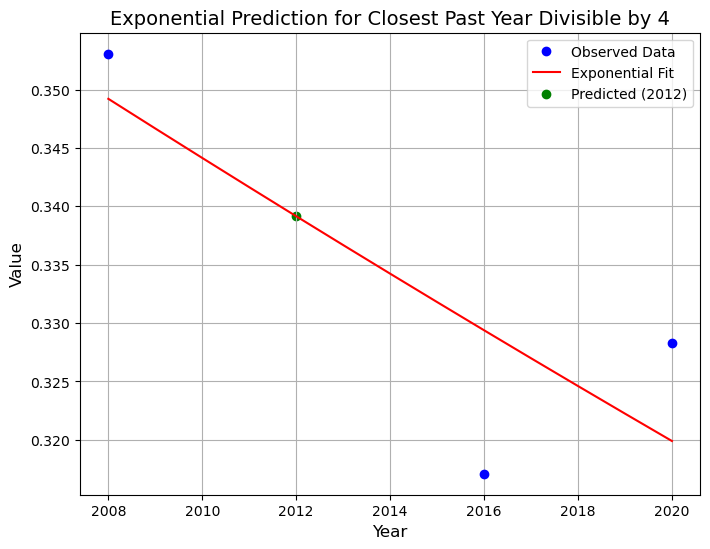

In [40]:
# Example usage
x_observed = np.array([2008, 2016, 2020])  # Observed years
y_observed = np.array([0.353084125509256, 0.317087778401647, 0.328329515706806])  # Observed values
year = 2013  # Target year

predicted_value, closest_year, params = predict_exponential_for_closest_past_year(y_observed, year)
if predicted_value is not None:
    print(f"Predicted value for the closest past year divisible by 4 ({closest_year}): {predicted_value}")

def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Plot the results
x_all = np.arange(min(x_observed), max(x_observed) + 1)
x_all_normalized = x_all - np.mean(x_observed)
a, b = params
y_all = exponential_model(x_all_normalized, a, b)

plt.figure(figsize=(8, 6))
plt.plot(x_observed, y_observed, 'bo', label='Observed Data')
plt.plot(x_all, y_all, 'r-', label='Exponential Fit')
plt.scatter([closest_year], [predicted_value], color='green', label=f'Predicted ({closest_year})')
plt.title("Exponential Prediction for Closest Past Year Divisible by 4", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [41]:
def compute_pres_pctD(row):
    # Extract observed percentage values for Democratic votes in past elections (2008, 2016, 2020) from the row
    y_observed = row[["pres_pctD_08", "pres_pctD_16", "pres_pctD_20"]].values.astype(float)

    # Predict the Democratic vote percentage for the specified year in the row
    predicted_value, *_ = predict_exponential_for_closest_past_year(y_observed, row["year"])
    return predicted_value

# Drop rows where 'pres_pctD_08' (Democratic vote percentage for 2008) is missing
df_mayor = df_mayor.dropna(subset=['pres_pctD_08'])

# This calculates the predicted Democratic vote percentage and stores it in a new column 'pres_pctD'
df_mayor["pres_pctD"] = df_mayor.apply(compute_pres_pctD, axis=1)

# These columns are no longer needed since their values have been used for prediction
df_mayor = df_mayor.drop(columns=["pres_pctD_20", "pres_pctD_16", "pres_pctD_08"])

In [42]:
display(df_mayor)

,state_abb,geo_name,year,contest,fips,full_name_rep,vote_share_rep,incumbent_rep,contributor.cfscore_rep,prob_democrat_rep,...,full_name_dem,vote_share_dem,incumbent_dem,contributor.cfscore_dem,prob_democrat_dem,gender_est_dem,race_est_dem,pid_est_dem,percent_women,pres_pctD
0,DE,wilmington,1992,1077580_1992_11_wilmington_DE_Mayor_mayor_1,1077580,beatrice patton carroll,0.090000,NaN,NaN,0.0,...,james sills,0.910000,NaN,-0.32,1.0,M,black,D,0.525989,0.891903
1,DE,wilmington,1996,1077580_1996_11_wilmington_DE_Mayor_mayor_1,1077580,bradley zuber,0.390000,0.0,NaN,0.0,...,james sills,0.610000,1.0,-0.32,1.0,M,black,D,0.525989,0.890173
2,DE,wilmington,2004,1077580_2004_11_wilmington_DE_Mayor_mayor_1,1077580,robert bovell,0.270000,0.0,NaN,0.0,...,james baker,0.730000,1.0,0.79,1.0,M,caucasian,D,0.525989,0.886721
3,DE,wilmington,2016,1077580_2016_11_wilmington_DE_Mayor_mayor_1,1077580,robert martin,0.118280,0.0,1.01,0.0,...,michael purzycki,0.881720,0.0,NaN,1.0,M,caucasian,D,0.525989,0.878289
4,DC,washington,1990,1150000_1990_11_washington_DC_Mayor_mayor_1,1150000,maurice turner,0.113402,NaN,NaN,0.0,...,sharon pratt dixon,0.886598,NaN,NaN,1.0,F,black,D,0.525549,0.914489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,CT,waterbury,2013,980000_2013_11_waterbury_CT_Mayor_mayor_1,980000,jason van stone,0.232558,0.0,NaN,0.0,...,neil o'leary,0.767442,1.0,-0.14,1.0,M,caucasian,D,0.520623,0.624277
1506,CT,waterbury,2019,980000_2019_11_waterbury_CT_Mayor_mayor_1,980000,raymond work,0.224719,0.0,0.89,0.0,...,neil o'leary,0.775281,1.0,-0.14,1.0,M,caucasian,D,0.520623,0.607515
1507,CT,west haven,2017,982800_2017_11_west haven_CT_Mayor_mayor_1,982800,david riccio,0.400000,0.0,1.13,0.0,...,nancy r rossi,0.600000,0.0,-0.16,1.0,F,caucasian,D,0.499918,0.649958
1508,CT,west haven,2019,982800_2019_11_west haven_CT_Mayor_mayor_1,982800,michele p gregorio,0.400000,0.0,1.06,0.0,...,nancy r rossi,0.600000,1.0,-0.16,1.0,F,caucasian,D,0.499918,0.649958


### Data imputation

In [43]:
rep_distribution = df_mayor['incumbent_rep'].value_counts()
dem_distribution = df_mayor['incumbent_dem'].value_counts()

print("Distribution of 'incumbency_rep':")
print(rep_distribution)
print("\nDistribution of 'incumbency_dem':")
print(dem_distribution)

# Impute Nan values in 'incumbent_rep' and 'incumbent_dem' columns with 0 (the most common value)
# I also googled several elections in the internet manually and they were all non-incumbent
df_mayor["incumbent_dem"].fillna(0, inplace=True)
df_mayor["incumbent_rep"].fillna(0, inplace=True)

Distribution of 'incumbency_rep':
incumbent_rep
0.0    930
1.0    336
Name: count, dtype: int64

Distribution of 'incumbency_dem':
incumbent_dem
0.0    810
1.0    456
Name: count, dtype: int64


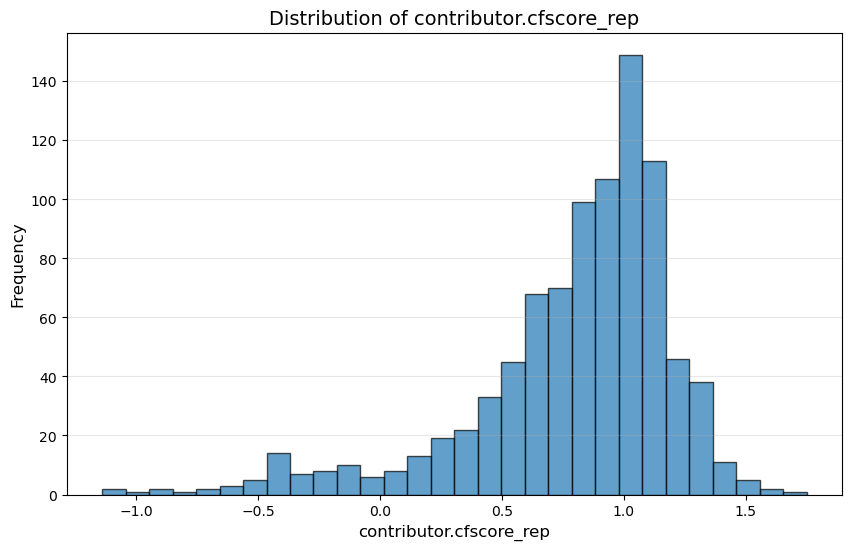

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(df_mayor["contributor.cfscore_rep"].dropna(), bins=30, edgecolor="black", alpha=0.7)
plt.title("Distribution of contributor.cfscore_rep", fontsize=14)
plt.xlabel("contributor.cfscore_rep", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.show()

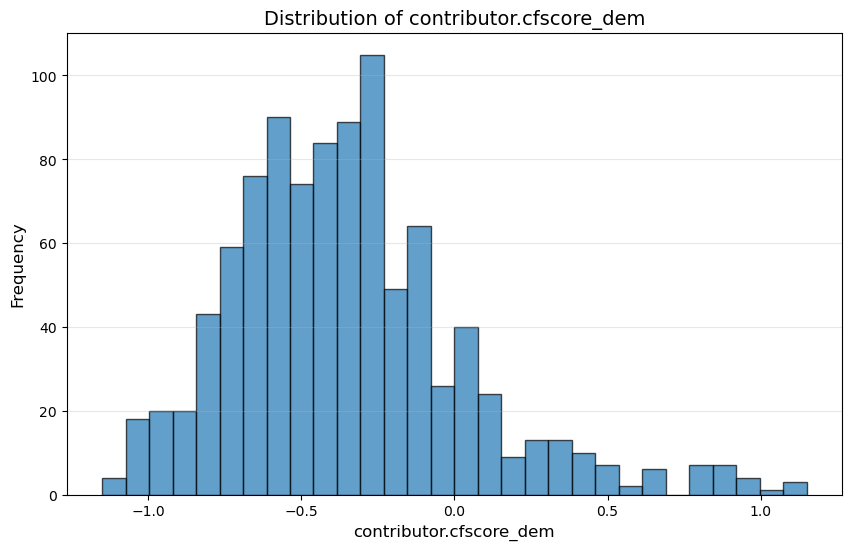

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(df_mayor["contributor.cfscore_dem"].dropna(), bins=30, edgecolor="black", alpha=0.7)
plt.title("Distribution of contributor.cfscore_dem", fontsize=14)
plt.xlabel("contributor.cfscore_dem", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.show()

In [46]:
df_mayor.isna().sum()[df_mayor.isna().sum() > 0]

contributor.cfscore_rep    582
gender_est_rep              48
race_est_rep                12
contributor.cfscore_dem    525
gender_est_dem              47
race_est_dem                 7
dtype: int64

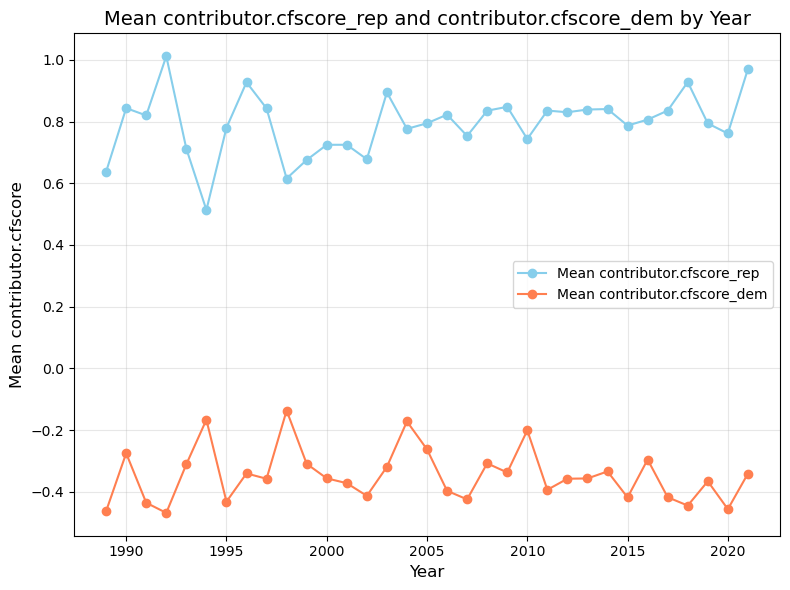

In [47]:
# Group by year and calculate mean of both columns
mean_rep = df_mayor.groupby("year")["contributor.cfscore_rep"].mean()
mean_dem = df_mayor.groupby("year")["contributor.cfscore_dem"].mean()

# Plot the mean values for both rep and dem on the same graph
plt.figure(figsize=(8, 6))
plt.plot(
    mean_rep.index, 
    mean_rep.values, 
    marker="o", 
    color="skyblue", 
    linestyle="-", 
    label="Mean contributor.cfscore_rep"
)
plt.plot(
    mean_dem.index, 
    mean_dem.values, 
    marker="o", 
    color="coral", 
    linestyle="-", 
    label="Mean contributor.cfscore_dem"
)
plt.title("Mean contributor.cfscore_rep and contributor.cfscore_dem by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean contributor.cfscore", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
# Calculate the mean values for each year for both columns
mean_rep_by_year = df_mayor.groupby("year")["contributor.cfscore_rep"].mean()
mean_dem_by_year = df_mayor.groupby("year")["contributor.cfscore_dem"].mean()

mean_rep_by_year_dict = mean_rep_by_year.to_dict()
mean_dem_by_year_dict = mean_dem_by_year.to_dict()

# Iterate through each row and impute missing values
for index, row in df_mayor.iterrows():
    year = row["year"]
    if pd.isna(row["contributor.cfscore_rep"]):
        df_mayor.at[index, "contributor.cfscore_rep"] = mean_rep_by_year_dict.get(year)
    if pd.isna(row["contributor.cfscore_dem"]):
        df_mayor.at[index, "contributor.cfscore_dem"] = mean_dem_by_year_dict.get(year)

In [49]:
df_mayor.isna().sum()[df_mayor.isna().sum() > 0]

gender_est_rep    48
race_est_rep      12
gender_est_dem    47
race_est_dem       7
dtype: int64

In [50]:
def find_missing_df(df_mayor, df, column_name, party):
    """
    Finds rows in df_mayor where a party-specific column has missing values and attempts to fill them using df.
    Returns:
    DataFrame: Rows with missing values in the party-specific column after attempted filling.
    """
    # Create party-specific column name
    column_name_party = f"{column_name}_{party}"
    full_name_party = f"full_name_{party}"

    # Prepare df for merging
    df = df[['full_name', column_name]].copy()
    df['full_name'] = df['full_name'].astype(str)

    # Filter rows in df_mayor with missing values in the party-specific column
    missing_df = df_mayor[df_mayor[column_name_party].isna()].copy()
    missing_df[full_name_party] = missing_df[full_name_party].astype(str)

    # Rename column for compatibility during merging
    missing_df.rename(columns={full_name_party: 'full_name'}, inplace=True)

    # Merge missing_df with df to fill missing values
    merged_df = missing_df.merge(df, how="left", on="full_name")

    # Filter rows where the column is still missing after the merge
    remaining_missing_df = merged_df[merged_df[column_name].isna()]

    # Select relevant columns and remove duplicates
    return remaining_missing_df[['full_name', 'contest', column_name_party]].drop_duplicates()

remaining_missing_df_rep = find_missing_df(df_mayor, df, 'race_est', 'rep')
display(remaining_missing_df_rep.head())

remaining_missing_df_dem = find_missing_df(df_mayor, df, 'race_est', 'dem')
display(remaining_missing_df_dem.head())


,full_name,contest,race_est_rep
0,david woods,151000_2019_10_montgomery_AL_Mayor_mayor_1,NaN
1,bill wilson,2148000_1998_11_louisville_KY_Mayor_mayor_1,NaN
2,mack 'bodi' white,2205000_2016_12_baton rouge_LA_Mayor_mayor_1,NaN
4,bob wallace,2404000_2020_11_baltimore_MD_Mayor_mayor_1,NaN
6,keith walker,3410000_1993_11_camden_NJ_Mayor_mayor_1,NaN


,full_name,contest,race_est_dem
3,kenneth welch,1263000_2021_11_st. petersburg_FL_Mayor_mayor_1,NaN
6,eileen hession weiss,1840788_1999_11_lafayette_IN_Mayor_mayor_1,NaN
7,terry whitt bailey,1851876_2019_11_muncie_IN_Mayor_mayor_1,NaN
8,sharon wolcott,471510_2011_11_surprise_AZ_Mayor_mayor_1,NaN
10,ruby faye woolridge,4804000_2019_5_arlington_TX_Mayor_mayor_1,NaN


In [51]:
def impute_missing_race_est(df_mayor, column_name, party, impute_values, missing_df):
    missing_df[column_name] = impute_values
    df_mayor.update(missing_df)

    column_name = column_name + '_' + party
    df_mayor[column_name] = np.where(df_mayor[column_name] == 'caucasian', 'white', 'non_white')
    return df_mayor

# Values checked manually
impute_values_rep = ['white', 'white', 'white', 'non-white', 'non-white', 'white', 'white', 'white', 'non-white', 'white', 'white', 'white']
df_mayor = impute_missing_race_est(df_mayor, 'race_est', 'rep', impute_values_rep, remaining_missing_df_rep)

# Values checked manually
impute_values_dem = ['non-white', 'white', 'non-white', 'white', 'non-white', 'white', 'white']
df_mayor = impute_missing_race_est(df_mayor, 'race_est', 'dem', impute_values_dem, remaining_missing_df_dem)

In [52]:
df_mayor.isna().sum()[df_mayor.isna().sum() > 0]

gender_est_rep    48
gender_est_dem    47
dtype: int64

In [53]:
display(df_mayor[df_mayor['gender_est_rep'].isna()][['full_name_rep', 'contest', 'gender_est_rep']].head())
display(df_mayor[df_mayor['gender_est_dem'].isna()][['full_name_dem', 'contest', 'gender_est_dem']].head())

,full_name_rep,contest,gender_est_rep
38,c daniel,3988000_2021_11_youngstown_OH_Mayor_mayor_1,NaN
71,j joe celestin,1249450_1999_5_north miami_FL_Mayor_mayor_1,NaN
72,j joe celestin,1249450_2001_5_north miami_FL_Mayor_mayor_1,NaN
129,david woods,151000_2019_10_montgomery_AL_Mayor_mayor_1,NaN
145,arvis,1705573_1997_NA_berwyn_IL_Mayor_mayor_1,NaN


,full_name_dem,contest,gender_est_dem
10,golene gordon,4804000_2019_5_arlington_TX_Mayor_mayor_1,NaN
96,kenneth welch,1263000_2021_11_st. petersburg_FL_Mayor_mayor_1,NaN
114,wl 'pug' mabry,1367284_1997_11_roswell_GA_Mayor_mayor_1,NaN
185,couri thomas,1759000_2017_4_peoria_IL_Mayor_mayor_1,NaN
202,m vining,1781048_2003_4_wheaton_IL_Mayor_mayor_1,NaN


In [54]:
def impute_column(df, column_name, impute_value, exception_column, exception_values, exception_impute_value):
    """
    Imputes a specified value into a column, with exceptions for specific rows.
    Returns:
    DataFrame: The DataFrame with the imputed column.
    """
    df.loc[df[exception_column].isin(exception_values), column_name] = exception_impute_value
    
    df.loc[
        df[column_name].isna() & ~df[exception_column].isin(exception_values),
        column_name
    ] = impute_value

    return df

# Values checked manually
df_mayor = impute_column(
    df=df_mayor,
    column_name='gender_est_rep',
    impute_value='M',
    exception_column='full_name_rep',
    exception_values=['tracey winbush', 'kim white'],
    exception_impute_value='F'
)

# Values checked manually
df_mayor = impute_column(
    df=df_mayor,
    column_name='gender_est_dem',
    impute_value='M',
    exception_column='full_name_dem',
    exception_values=[
        'golene gordon', 'eileen hession weiss', 'sharon weston broome',
        'j carlvena foster', 'lindgren', 'wanda rd williams',
        'sharon wolcott', 'ruby faye woolridge', 'meyera oberndorf',
        'jody wagner'
    ],
    exception_impute_value='F'
)


In [55]:
df_mayor.isna().sum()[df_mayor.isna().sum() > 0]

Series([], dtype: int64)

In [56]:
df_mayor.head()

,state_abb,geo_name,year,contest,fips,full_name_rep,vote_share_rep,incumbent_rep,contributor.cfscore_rep,prob_democrat_rep,...,full_name_dem,vote_share_dem,incumbent_dem,contributor.cfscore_dem,prob_democrat_dem,gender_est_dem,race_est_dem,pid_est_dem,percent_women,pres_pctD
0,DE,wilmington,1992,151000_2019_10_montgomery_AL_Mayor_mayor_1,1077580,beatrice patton carroll,0.090000,0.0,1.011667,0.0,...,james sills,0.910000,0.0,-0.320000,1.0,M,non_white,D,0.525989,0.891903
1,DE,wilmington,1996,2148000_1998_11_louisville_KY_Mayor_mayor_1,1077580,bradley zuber,0.390000,0.0,0.927143,0.0,...,james sills,0.610000,1.0,-0.320000,1.0,M,non_white,D,0.525989,0.890173
2,DE,wilmington,2004,2205000_2016_12_baton rouge_LA_Mayor_mayor_1,1077580,robert bovell,0.270000,0.0,0.776190,0.0,...,james baker,0.730000,1.0,0.790000,1.0,M,white,D,0.525989,0.886721
3,DE,wilmington,2016,1263000_2021_11_st. petersburg_FL_Mayor_mayor_1,1077580,robert martin,0.118280,0.0,1.010000,0.0,...,michael purzycki,0.881720,0.0,-0.295000,1.0,M,white,D,0.525989,0.878289
4,DC,washington,1990,2404000_2020_11_baltimore_MD_Mayor_mayor_1,1150000,maurice turner,0.113402,0.0,0.843333,0.0,...,sharon pratt dixon,0.886598,0.0,-0.274545,1.0,F,non_white,D,0.525549,0.914489


In [57]:
df_mayor.to_csv('data/data_mayoral.csv', index=False)